# This is a pipeline to visualize and analyze the results of CellProfiler on Rabies experiments

In [210]:
%load_ext autoreload
%autoreload 2
import os
from utils import data_reader, plot_utils
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pylab as plt
from PIL import Image
from matplotlib import cm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
# Select the path where the data is (the output of CellProfiler)
Data_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Rabies_Tracing/ToS-D1_D2/DataForAnalysis/'
# Read it in a useful format
RabiesData, cFosData = data_reader.RabiesCP_data_reader(Data_path + 'CellProfilerOutput/')

In [212]:
cFosData.BrainSide

0       Contra
1       Contra
2         Ipsi
3         Ipsi
4         Ipsi
5         Ipsi
6         Ipsi
7         Ipsi
8         Ipsi
9         Ipsi
10        Ipsi
11        Ipsi
12        Ipsi
13        Ipsi
14        Ipsi
15        Ipsi
16      Contra
17      Contra
18      Contra
19      Contra
20      Contra
21      Contra
22      Contra
23      Contra
24      Contra
25      Contra
26      Contra
27      Contra
28      Contra
29      Contra
         ...  
2477    Contra
2478    Contra
2479    Contra
2480    Contra
2481    Contra
2482    Contra
2483    Contra
2484    Contra
2485    Contra
2486    Contra
2487      Ipsi
2488      Ipsi
2489      Ipsi
2490      Ipsi
2491      Ipsi
2492      Ipsi
2493      Ipsi
2494      Ipsi
2495      Ipsi
2496      Ipsi
2497      Ipsi
2498      Ipsi
2499      Ipsi
2500      Ipsi
2501      Ipsi
2502      Ipsi
2503      Ipsi
2504      Ipsi
2505      Ipsi
2506      Ipsi
Name: BrainSide, Length: 2507, dtype: object

/home/hmvergara/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


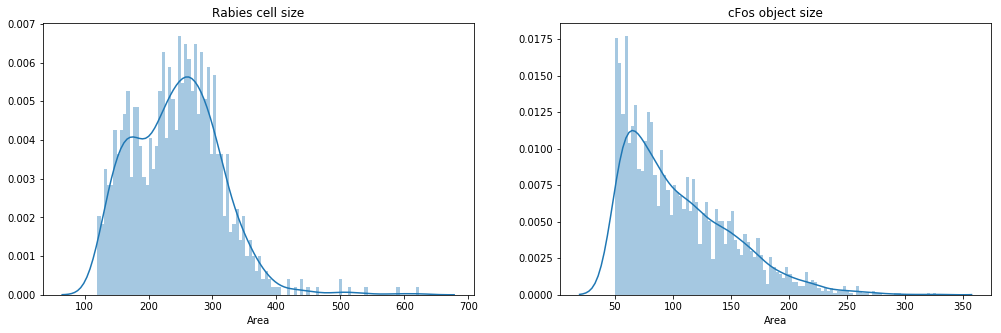

In [213]:
# cell area size
fig, axs = plt.subplots(1,2, figsize=(17,5))
axs = axs.ravel()
sns.distplot(RabiesData.Area, bins=100, ax = axs[0])
axs[0].set_title('Rabies cell size')
sns.distplot(cFosData.Area, bins=100, ax = axs[1])
axs[1].set_title('cFos object size')
plt.show()

In [214]:
# filter by size
RabiesDataSF = RabiesData[RabiesData['Area']>200]
cFosDataSF = cFosData

In [215]:
# filter by side of the brain
RabiesDataSF = RabiesDataSF[RabiesDataSF['BrainSide']=='Ipsi']
cFosDataSF = cFosDataSF[cFosDataSF['BrainSide']=='Ipsi']

In [228]:
percCol = 'cFosPercentile_med_Object'

TotalRabiesD1 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D1'])
TotalRabiesD2 = len(RabiesDataSF[RabiesDataSF['StarterCells']=='D2'])
TotalcFosD1 = len(cFosDataSF[np.logical_and(cFosDataSF['StarterCells']=='D1', cFosDataSF['PercentileInfo']==percCol)])
TotalcFosD2 = len(cFosDataSF[np.logical_and(cFosDataSF['StarterCells']=='D2', cFosDataSF['PercentileInfo']==percCol)])
TotalRabiesAndcfosD1 = len(RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D1')])
TotalRabiesAndcfosD2 = len(RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D2')])


print('Total rabies cells:')
print('D1: ',str(TotalRabiesD1))
print('D2: ',str(TotalRabiesD2))


print('\nTotal c-Fos objects:')
print('D1: ',str(TotalcFosD1))
print('D2: ',str(TotalcFosD2))

print('\nTotal rabies cells with c-Fos:')
print('D1: ',str(TotalRabiesAndcfosD1))
print('D2: ',str(TotalRabiesAndcfosD2))


# Maybe this is not a good way of normalizing using the c-Fos (e.g. this is not robust to only c-Fos images).
# sOne way could be to normalize the c-Fos by the c-Fos density? (total cFos / total image area)

print('\nPercentage verlap of rabies and c-Fos:')
print('D1: ',str(100 * TotalRabiesAndcfosD1 / (TotalcFosD1 + TotalRabiesD1)), '%')
print('D2: ',str(100 * TotalRabiesAndcfosD2 / (TotalcFosD2 + TotalRabiesD2)), '%')

print('\nProportion of rabies cells with c-Fos:')
print('D1: ',str(100 * TotalRabiesAndcfosD1 / (TotalRabiesD1)), '%')
print('D2: ',str(100 * TotalRabiesAndcfosD2 / (TotalRabiesD2)), '%')

Total rabies cells:
D1:  95
D2:  359

Total c-Fos objects:
D1:  78
D2:  236

Total rabies cells with c-Fos:
D1:  2
D2:  11

Percentage verlap of rabies and c-Fos:
D1:  1.1560693641618498 %
D2:  1.8487394957983194 %

Proportion of rabies cells with c-Fos:
D1:  2.1052631578947367 %
D2:  3.064066852367688 %


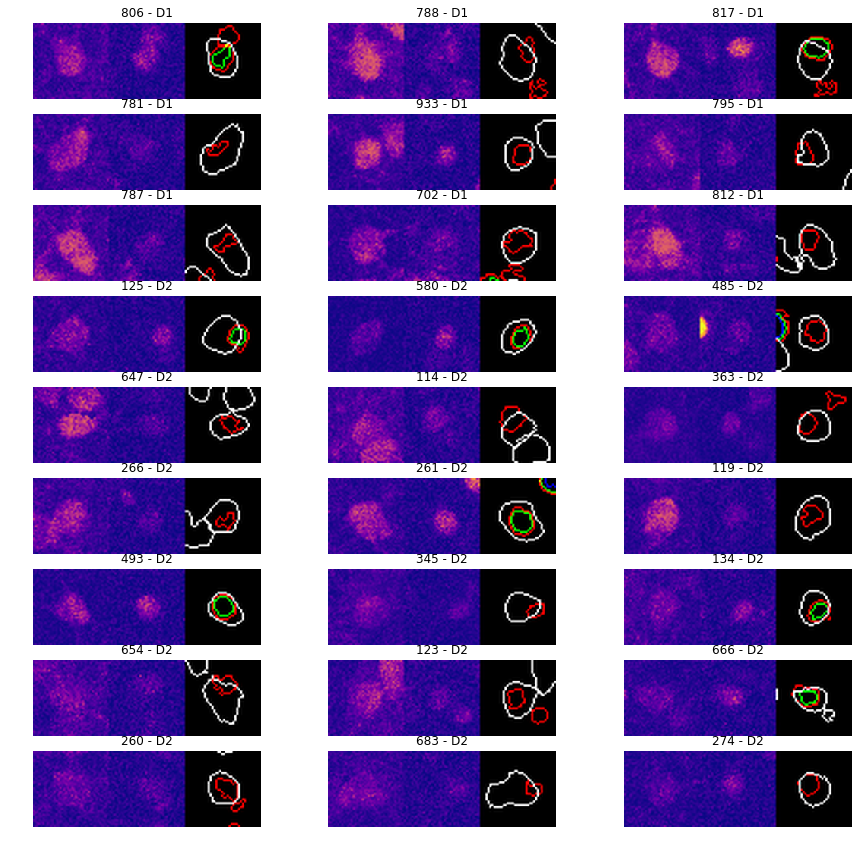

In [226]:
# explore the dataset, plotting a random subset of cells
NumOfSamples = 36
# get the indexes of d1 and d2 cohorts
d1shuffledIdx = RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D1')].index.values
d2shuffledIdx = RabiesDataSF[np.logical_and(RabiesDataSF[percCol]!=0, RabiesDataSF['StarterCells']=='D2')].index.values
# shuffle them
np.random.shuffle(d1shuffledIdx)
np.random.shuffle(d2shuffledIdx)
# join
IdxToPlot = list(d1shuffledIdx[0:int(NumOfSamples/2)]) + list(d2shuffledIdx[0:int(NumOfSamples/2)])
# plot
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(5*NumOfSamples/3)))
for counter,i in enumerate(IdxToPlot):
    CellImage = plot_utils.plotRabiesCell(RabiesData.iloc[i], Data_path, window=20, lut='plasma')
    plt.subplot(NumOfSamples, 3, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i) + " - " + RabiesData.iloc[i]['StarterCells'])
    plt.imshow(CellImage)




In [209]:
RabiesData[['cFosPercentile_med_Object', 'cFosPercentile_high_Object']].apply(len)

cFosPercentile_med_Object     981
cFosPercentile_high_Object    981
dtype: int64

In [195]:
RabiesDataSF[np.logical_and(RabiesDataSF['ImageNumber']==1, np.logical_or(
                            RabiesDataSF['RabiesCellNumber']==23, RabiesDataSF['RabiesCellNumber']==24))]

,ImageNumber,RabiesCellNumber,Area,Center_X,Center_Y,MeanIntensity_cfos,MeanIntensity_rabies,cFosPercentile_high_Object,cFosPercentile_low_Object,cFosPercentile_med_Object,AnimalID,StarterCells,cFosCondition,SliceNumber,BrainSide,InjectionArea
22,1.0,23.0,429.0,281.0,455.0,0.074903,0.260432,0.0,19.0,0.0,893271,D2,Punish,Slice6,Contra,TODO
23,1.0,24.0,302.0,226.0,507.0,0.072419,0.345708,0.0,0.0,0.0,893271,D2,Punish,Slice6,Contra,TODO


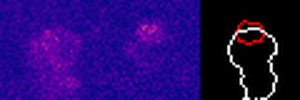

In [196]:
plot_utils.plotRabiesCell(RabiesData.iloc[22], Data_path, window=20, lut='plasma')

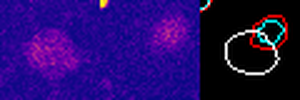

In [197]:
plot_utils.plotRabiesCell(RabiesData.iloc[23], Data_path, window=20, lut='plasma')

In [ ]:
# Check and maybe filter different parameters